<a href="https://colab.research.google.com/github/NeetishPathak/biz_machine_learning/blob/main/Classifier/Payment_Fraud_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Online Payment Fraud Classifier

It is extremely important for online payment companies to classify the transactions as legitimate or fraudulent for good business and protecing their customers.

In this project, we will classify payments as fradulent or non-fradualent using decison tree based machine learning models. 
We need information about online payments to understand what factors can lead to frauds. 

We will use dataset from [Kaggle] (https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset)

Column Reference from dataset

1. step: represents a unit of time where 1 step equals 1 hour
2. type: type of online transaction
3. amount: the amount of the transaction
4. nameOrig: customer starting the transaction
5. oldbalanceOrg: balance before the transaction
6. newbalanceOrig: balance after the transaction
7. nameDest: recipient of the transaction
8. oldbalanceDest: initial balance of recipient before the transaction
9. newbalanceDest: the new balance of recipient after the transaction
10. isFraud: fraud transaction

Download the file from this [LINK](https://drive.google.com/uc?export=download&id=1ZTlyuWfspKtOhj7p2uBwHjzfjcIHDfmC) - Full dataset csv filesize is 493MB and has 6.36 million records. Takes longer to load. 

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn import preprocessing

In [30]:
# Loading the online-payments.csv from kaggle dataset - https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
fileUrl="https://media.githubusercontent.com/media/NeetishPathak/biz_machine_learning/main/Classifier/online-payments.csv"

# Otherwise follwing example will use a compact version of the file from the link below
# fileUrl="https://raw.githubusercontent.com/NeetishPathak/biz_machine_learning/main/Classifier/compact-online-payments.csv"

data = pd.read_csv(fileUrl)

In [31]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [32]:
data.shape

(6362620, 11)

## Exploratory Analysis

In [33]:
print('Number of NAN values: {}'.format(data.isna().sum()))
data.dropna(inplace=True) # Dropping NANs

Number of NAN values: step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [34]:
# Exploring - Type of transactions
print(data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


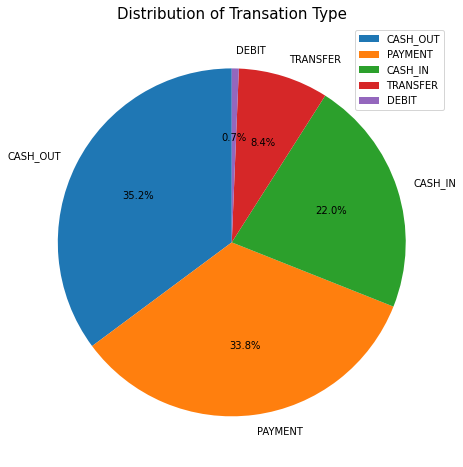

In [35]:
# Let's visualize the distribution of the dataset using a pie chart
type = data["type"].value_counts()
transactions = type.index
quantity = type.values


labels = transactions
sections = quantity

plt.figure(figsize=(8,8))
plt.pie(sections,labels=labels, startangle=90,autopct="%1.1f%%")
plt.title("Distribution of Transation Type",fontsize=15)
plt.legend()
plt.show()



0    6354407
1       8213
Name: isFraud, dtype: int64


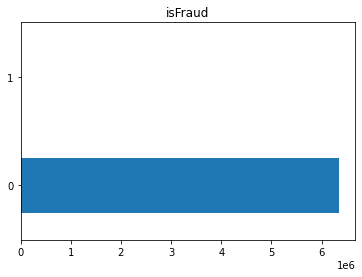

In [36]:
# Visualize the distribution of fraudulent vs non-fraudulent transaction using bar chart
# 0 represents non fradulanet transaction and 1 represents fraudulent transactions
print(data.isFraud.value_counts())
data.isFraud.value_counts().plot(kind='barh', title='isFraud')
plt.show()

In [37]:
y=data.pop('isFraud') # Removing Churn field and storing it in variable y
y

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: int64

In [38]:
categorical_cols = data.columns[data.dtypes=='object'].tolist()
categorical_cols

['type', 'nameOrig', 'nameDest']

In [39]:
categorical_cols = ['type']

In [40]:
features_data = data[['type','amount', 'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']]
features_data

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,0
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,0
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,0
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,0
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,0
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,0


In [41]:
# Create dummy variables
data = pd.get_dummies(data=features_data, columns=categorical_cols, drop_first=False)
data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,0,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,0,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,0,0,1,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,0,1
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,0,1,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,0,1


In [42]:
# Let's have a look at the correlation between the features in the data with the isFraud column
t_data=data.copy()
t_data['isFraud']=y
corr = t_data.corr()
print("Correleation Matrix")
corr

Correleation Matrix


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.012295,-0.009621,-0.004376,-0.023379,-0.197444,0.365896,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.003835,0.506761,-0.200899,-0.021450,-0.189486,-0.081593,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,0.003776,0.527373,-0.210977,-0.021872,-0.193915,-0.087355,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.000513,0.076105,0.086028,0.009347,-0.231455,0.130476,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,-0.000529,0.034988,0.093476,0.006346,-0.238315,0.191701,0.000535
isFlaggedFraud,0.012295,0.003835,0.003776,-0.000513,-0.000529,1.000000,-0.000842,-0.001168,-0.000128,-0.001133,0.005245,0.044109
type_CASH_IN,-0.009621,0.506761,0.527373,0.076105,0.034988,-0.000842,1.000000,-0.391047,-0.042987,-0.379522,-0.160535,-0.019089
type_CASH_OUT,-0.004376,-0.200899,-0.210977,0.086028,0.093476,-0.001168,-0.391047,1.000000,-0.059625,-0.526422,-0.222672,0.011256
type_DEBIT,-0.023379,-0.021450,-0.021872,0.009347,0.006346,-0.000128,-0.042987,-0.059625,1.000000,-0.057868,-0.024478,-0.002911
type_PAYMENT,-0.197444,-0.189486,-0.193915,-0.231455,-0.238315,-0.001133,-0.379522,-0.526422,-0.057868,1.000000,-0.216110,-0.025697


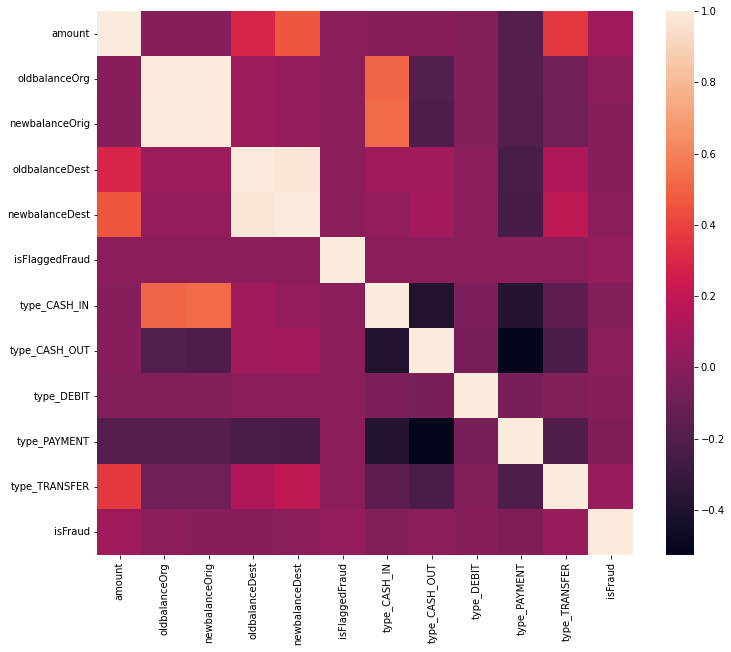

In [43]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr)
plt.show()

In [44]:
print("Correlation of features with isFraud")
print(corr['isFraud'].sort_values(ascending=False))

Correlation of features with isFraud
isFraud           1.000000
amount            0.076688
type_TRANSFER     0.053869
isFlaggedFraud    0.044109
type_CASH_OUT     0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
type_DEBIT       -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_CASH_IN     -0.019089
type_PAYMENT     -0.025697
Name: isFraud, dtype: float64


In [45]:
data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,0,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,0,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,0,0,1,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,0,0,0,0,0,1
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,0,0,1,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,0,1


In [46]:
X = data[['amount','oldbalanceOrg','newbalanceDest','type_TRANSFER','isFlaggedFraud','type_CASH_OUT']]

## Splitting the Data for fraud detection


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)

In [48]:
X_train.head()

,amount,oldbalanceOrg,newbalanceDest,type_TRANSFER,isFlaggedFraud,type_CASH_OUT
3440419,296617.39,3756237.67,143855.77,0,0,0
6308479,1467968.73,1467968.73,0.00,1,0,0
4373623,288552.63,20865.00,0.00,0,0,0
4155401,313215.72,6019480.20,356481.42,0,0,0
2400017,321296.80,42.00,380523.91,0,0,1


## Train the model

## Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=5)

print(dt_model)

dt_model = dt_model.fit(X_train,y_train)
pred_dt = dt_model.predict_proba(X_test)[:, 1]

DecisionTreeClassifier(max_depth=5)


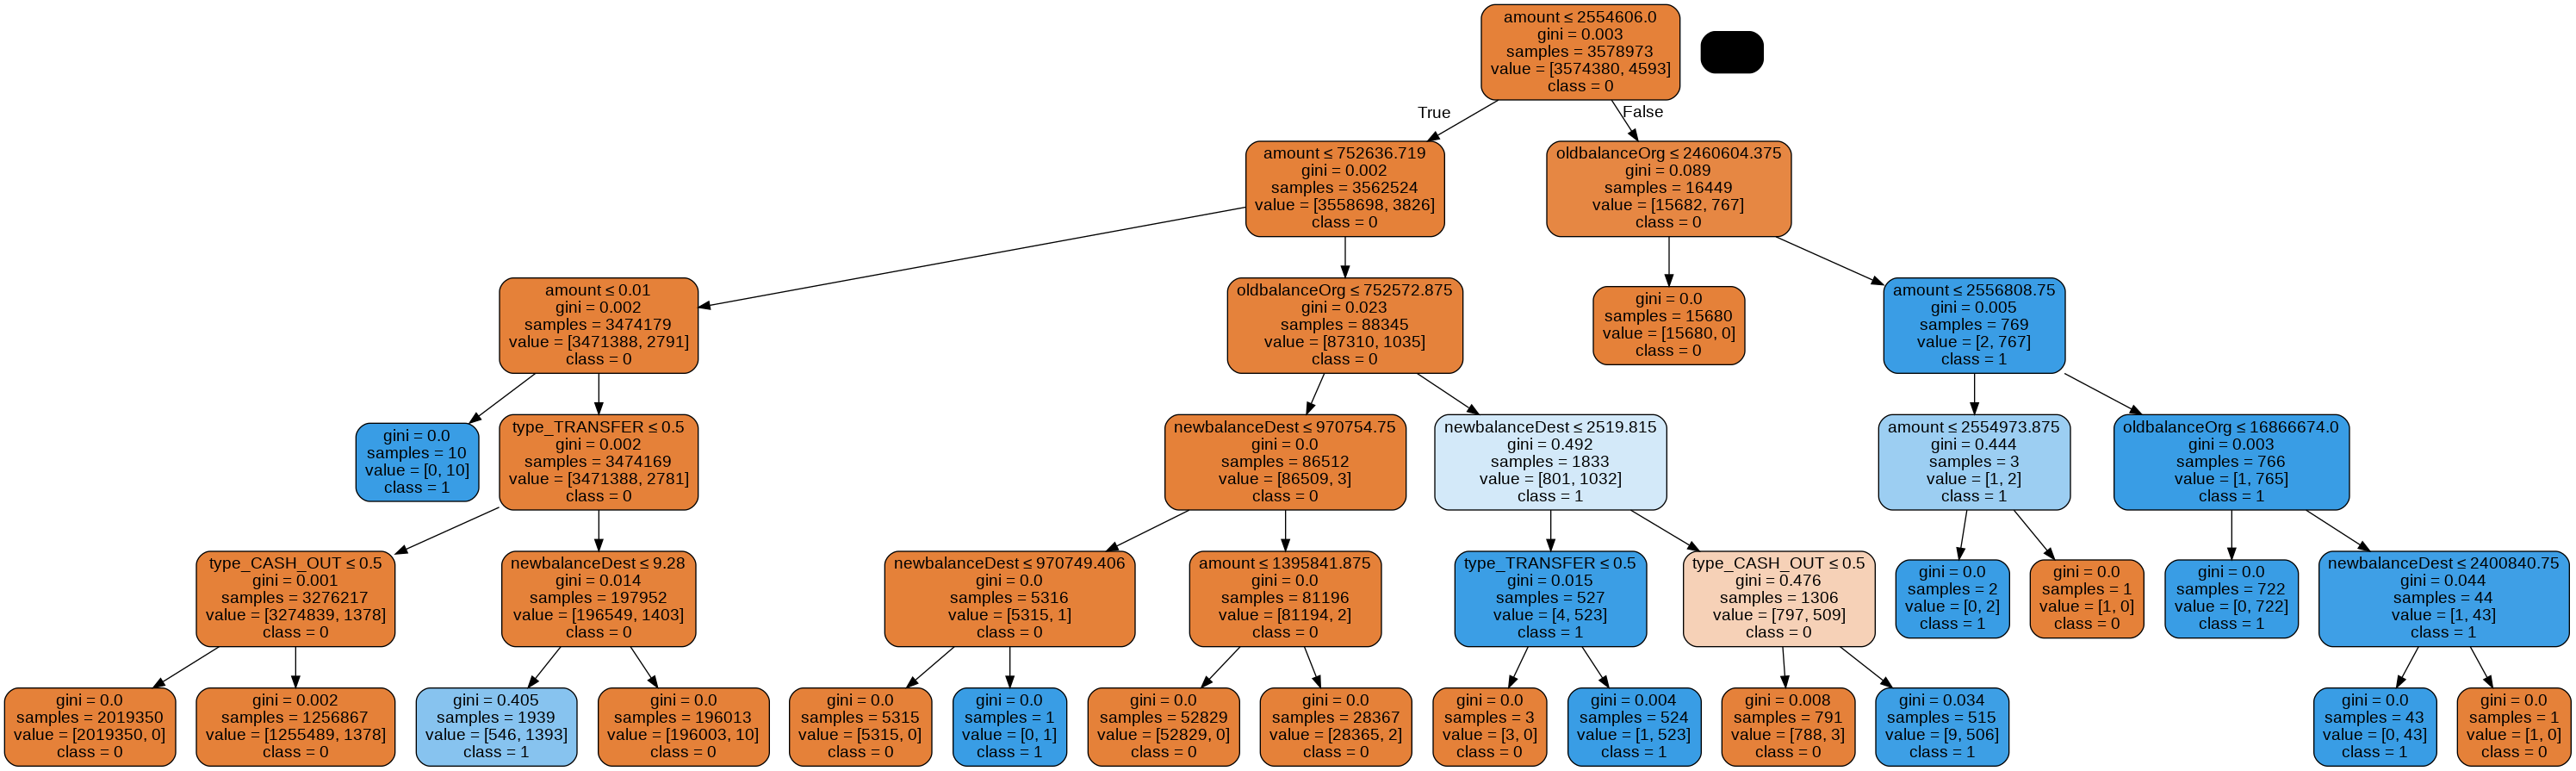

In [50]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns.values.tolist(), 
               class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Evaluate The Model

In [51]:
from sklearn.metrics import classification_report
pred_dt_binary = dt_model.predict(X_test)
print(classification_report(y_test, pred_dt_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588581
           1       0.85      0.68      0.75      2074

    accuracy                           1.00   1590655
   macro avg       0.92      0.84      0.88   1590655
weighted avg       1.00      1.00      1.00   1590655




When classifying 'Fraud', 

precision is proportion transactions predicted fraud were actually fraud.

recall is the proportion of actual fraud transactions were correctly predicted.

In case of online transactions,we want a classifier with higher recall

In [52]:
def create_roc_plot(name, predictions):
  auc = roc_auc_score(y_test, predictions).round(2)
  fpr, tpr, _ = roc_curve(y_test, predictions)

  plt.figure(figsize=(10, 8))
  plt.plot([0, 1], [0, 1], linestyle='--')  # plot horizontal line 
  plt.plot(fpr, tpr, label='{} AUC = {}'.format(name, auc)) # plot the roc curve for the model
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='lower right')  # show the legend
  plt.show() # show the plot
  return None

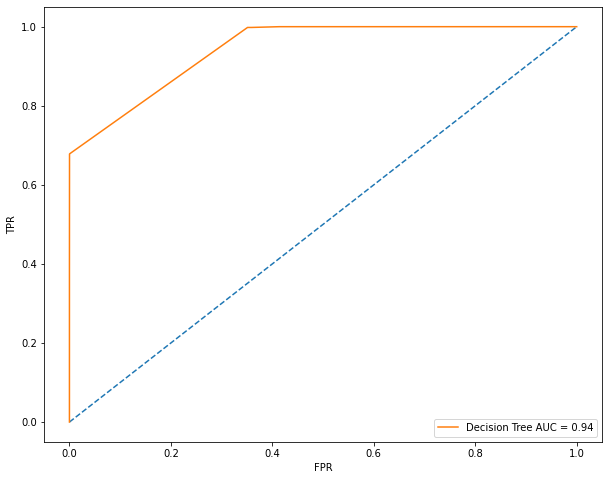

In [53]:
create_roc_plot('Decision Tree', pred_dt)